In [ ]:
!wget -nc https://lazyprogrammer.me/course_files/sp500sub.csv

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv('sp500sub.csv', index_col='Date', parse_dates=True)

In [ ]:
df.columns

In [ ]:
df['Name'].unique()

In [ ]:
# names = df['Name'].unique()
names = ['GOOG', 'SBUX', 'KSS', 'NEM']

In [ ]:
252/2

In [ ]:
all_dates = df.index.unique().sort_values()

In [ ]:
len(all_dates)

In [ ]:
all_dates.get_loc('2014-01-02')

In [ ]:
all_dates.get_loc('2014-06-30')

In [ ]:
start = all_dates.get_loc('2014-01-02')
end = all_dates.get_loc('2014-06-30')
dates = all_dates[start:end+1]

In [ ]:
type(dates)

In [ ]:
len(dates)

In [ ]:
close_prices = pd.DataFrame(index=dates)

In [ ]:
tmp1 = df.loc[dates]
for name in names:
  df_sym = tmp1[tmp1['Name'] == name]
  df_tmp = pd.DataFrame(data=df_sym['Close'].to_numpy(), \
                        index=df_sym.index, columns=[name])
  close_prices = close_prices.join(df_tmp) # left-join by default

In [ ]:
close_prices.head()

In [ ]:
close_prices.isna().sum().sum()

In [ ]:
close_prices.fillna(method='ffill', inplace=True)

In [ ]:
close_prices.isna().sum().sum()

In [ ]:
# empty dataframe
returns = pd.DataFrame(index=dates[1:])

In [ ]:
for name in names:
  current_returns = close_prices[name].pct_change()
  returns[name] = current_returns.iloc[1:] * 100

In [ ]:
returns.head()

In [ ]:
mean_return = returns.mean()

In [ ]:
mean_return

In [ ]:
cov = returns.cov()

In [ ]:
cov

In [ ]:
cov_np = cov.to_numpy()

In [ ]:
N = 10000
D = len(mean_return)
returns = np.zeros(N)
risks = np.zeros(N)
random_weights = []
for i in range(N):
  rand_range = 1.0
  w = np.random.random(D)*rand_range - rand_range / 2 # with short-selling
  w[-1] = 1 - w[:-1].sum()
  np.random.shuffle(w)
  random_weights.append(w)
  ret = mean_return.dot(w)
  risk = np.sqrt(w.dot(cov_np).dot(w))
  returns[i] = ret
  risks[i] = risk

In [ ]:
single_asset_returns = np.zeros(D)
single_asset_risks = np.zeros(D)
for i in range(D):
  ret = mean_return[i]
  risk = np.sqrt(cov_np[i,i])

  single_asset_returns[i] = ret
  single_asset_risks[i] = risk

In [ ]:
plt.scatter(risks, returns, alpha=0.1);
plt.scatter(single_asset_risks, single_asset_returns, c='red');

In [ ]:
for idx, val in cov['GOOG'].iteritems():
  print(idx, val)

## Max and Min Return

In [ ]:
from scipy.optimize import linprog

In [ ]:
D = len(mean_return)

In [ ]:
A_eq = np.ones((1, D))
b_eq = np.ones(1)

In [ ]:
### NOTE: The bounds are by default (0, None) unless otherwise specified.
# bounds = None
bounds = [(-0.5, None)]*D
bounds

In [ ]:
# minimize
res = linprog(mean_return, A_eq=A_eq, b_eq=b_eq, bounds=bounds)
res

In [ ]:
min_return = res.fun

In [ ]:
# maximize
res = linprog(-mean_return, A_eq=A_eq, b_eq=b_eq, bounds=bounds)
res

In [ ]:
max_return = -res.fun

In [ ]:
min_return, max_return

## Mean-Variance Optimal Portfolios

In [ ]:
N = 100
target_returns = np.linspace(min_return, max_return, num=N)

In [ ]:
from scipy.optimize import minimize

In [ ]:
def get_portfolio_variance(weights):
  return weights.dot(cov).dot(weights)

In [ ]:
def target_return_constraint(weights, target):
  return weights.dot(mean_return) - target

In [ ]:
def portfolio_constraint(weights):
  return weights.sum() - 1

In [ ]:
constraints = [
    {
        'type': 'eq',
        'fun': target_return_constraint,
        'args': [target_returns[0]], # will be updated in loop
    },
    {
        'type': 'eq',
        'fun': portfolio_constraint,
    }
]

In [ ]:
# check if it works
res = minimize(
    fun=get_portfolio_variance,
    x0=np.ones(D) / D, # uniform
    method='SLSQP',
    constraints=constraints,
)
res

In [ ]:
# Let's limit the magnitude of the weights
res = minimize(
    fun=get_portfolio_variance,
    x0=np.ones(D) / D, # uniform
    method='SLSQP',
    constraints=constraints,
    bounds=bounds,
)
res

In [ ]:
optimized_risks = []
for target in target_returns:
  # set target return constraint
  constraints[0]['args'] = [target]

  res = minimize(
      fun=get_portfolio_variance,
      x0=np.ones(D) / D, # uniform
      method='SLSQP',
      constraints=constraints,
      bounds=bounds,
  )
  optimized_risks.append(np.sqrt(res.fun))
  if res.status != 0:
    print(res)

In [ ]:
plt.scatter(risks, returns, alpha=0.1);
plt.plot(optimized_risks, target_returns, c='black');

In [ ]:
# Min variance portfolio
# Let's limit the magnitude of the weights
res = minimize(
    fun=get_portfolio_variance,
    x0=np.ones(D) / D, # uniform
    method='SLSQP',
    constraints={
        'type': 'eq',
        'fun': portfolio_constraint,
    },
    bounds=bounds,
)
res

In [ ]:
mv_risk = np.sqrt(res.fun)
mv_weights = res.x
mv_ret = mv_weights.dot(mean_return)

In [ ]:
plt.scatter(risks, returns, alpha=0.1);
plt.plot(optimized_risks, target_returns, c='black');
plt.scatter([mv_risk], [mv_ret], c='red');

## Sharpe Ratio

In [ ]:
# https://fred.stlouisfed.org/series/TB3MS
risk_free_rate = 0.03 / 252

In [ ]:
def neg_sharpe_ratio(weights):
  mean = weights.dot(mean_return)
  sd = np.sqrt(weights.dot(cov).dot(weights))
  return -(mean - risk_free_rate) / sd

In [ ]:
res = minimize(
    fun=neg_sharpe_ratio,
    x0=np.ones(D) / D, # uniform
    method='SLSQP',
    constraints={
        'type': 'eq',
        'fun': portfolio_constraint,
    },
    bounds=bounds,
)
res

     fun: -0.059207597381964565
     jac: array([0.00937157, 0.00929031, 0.02811907, 0.00926263])
 message: 'Optimization terminated successfully.'
    nfev: 96
     nit: 16
    njev: 16
  status: 0
 success: True
       x: array([ 0.8422283 ,  0.11832917, -0.5       ,  0.53944253])

In [ ]:
best_sr, best_w = -res.fun, res.x

In [ ]:
mc_best_w = None
mc_best_sr = float('-inf')
for i, (risk, ret) in enumerate(zip(risks, returns)):
  sr = (ret - risk_free_rate) / risk
  if sr > mc_best_sr:
    mc_best_sr = sr
    mc_best_w = random_weights[i]
print(mc_best_w, mc_best_sr)

[ 0.82393863  0.18979659 -0.46790158  0.45416636] 0.05824302690936854


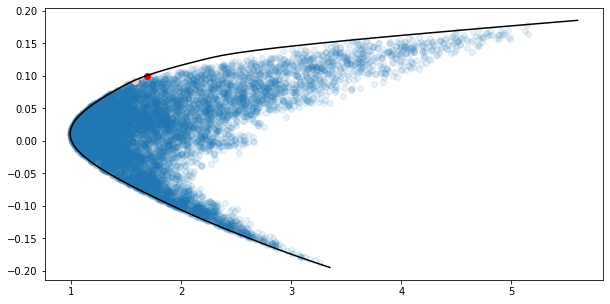

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
plt.scatter(risks, returns, alpha=0.1);
plt.plot(optimized_risks, target_returns, c='black');

# found by optimization
opt_risk = np.sqrt(best_w.dot(cov).dot(best_w))
opt_ret = mean_return.dot(best_w)
plt.scatter([opt_risk], [opt_ret], c='red');

# found by monte carlo simulation
mc_risk = np.sqrt(mc_best_w.dot(cov).dot(mc_best_w))
mc_ret = mean_return.dot(mc_best_w)
plt.scatter([mc_risk], [mc_ret], c='pink');

## Risk-free asset with tangency portfolio

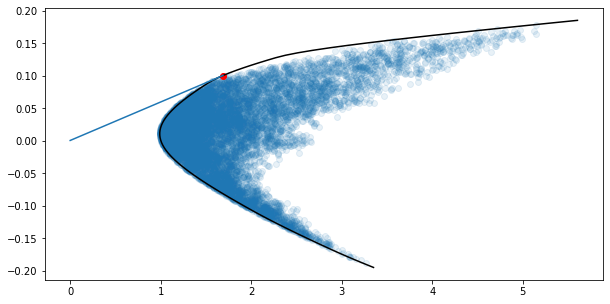

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
plt.scatter(risks, returns, alpha=0.1);
plt.plot(optimized_risks, target_returns, c='black');

# found by optimization
opt_risk = np.sqrt(best_w.dot(cov).dot(best_w))
opt_ret = mean_return.dot(best_w)
plt.scatter([opt_risk], [opt_ret], c='red');

# tangent line
x1 = 0
y1 = risk_free_rate
x2 = opt_risk
y2 = opt_ret
plt.plot([x1, x2], [y1, y2]);